# Prescriptive Models and Data Analytics Problem Set #4

## 1. Simple regressions: Regression without controls

**Question 1. Load ad heterog data and regress revenue on treatment without further controls. The data is from an A/B test. Interpret the intercept and the treatment coefficient.**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

In [2]:
ad_heterog = pd.read_csv('ad_heterog.csv')
ad_heterog.head()

,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,demographic_7,demographic_8,...,demographic_21,demographic_22,demographic_23,demographic_24,demographic_25,demographic_26,demographic_27,demographic_28,demographic_29,demographic_30
0,5.504899,0,1,1,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
1,5.554275,1,0,1,1,0,0,0,1,0,...,0,0,0,1,1,0,1,1,1,0
2,5.219492,0,0,1,1,0,0,1,1,1,...,0,1,0,1,0,1,1,0,0,1
3,4.565855,0,1,0,0,0,1,1,0,1,...,1,0,0,1,0,1,0,0,1,0
4,5.020636,0,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,0,0,1


In [3]:
ad_rev  = smf.ols(formula = 'revenue ~ treatment', data = ad_heterog)
result = ad_rev.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     779.2
Date:                Sat, 16 Mar 2024   Prob (F-statistic):          4.50e-145
Time:                        16:41:26   Log-Likelihood:                -1532.5
No. Observations:                2000   AIC:                             3069.
Df Residuals:                    1998   BIC:                             3080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1082      0.016    315.942      0.0

The intercept is 5.1082 with small p-value, indicating that the average revenue is 5.1082 when the treatment is not applied, in terms of the control group. The treatment coefficient of 0.6508 with small p-value implies that applying the treatment will significantly increase the average revenue by 0.6508, suggesting a positive effect on revenue.

**Question 2. Assume that it costs 0.7 Dollars to show the ad. Based on the previous regression, should you show the ad (assuming you either show it to all consumers or to nobody, i.e. you are not able to target the ad)?**

Based on the previous regression analysis, I believe it is not profitable to show the ad to all consumers. The cost of displaying the ad is 0.7 dollars, while the average revenue increase from showing the ad is only 0.6508 dollars. This suggests that the cost of displaying the ad exceeds the revenue increase, implying a net loss if the ad is shown to all customers.

## 2. Lasso with interactions

**Run the code below in order to generate a matrix of demographic variables as well as a matrix of interaction terms.**

In [4]:
# extract columns pertaining to demographic information (all columns except first two)
demo_matrix = ad_heterog.iloc[:,2:]
# generate interactions of each demographic variable with the treatment variable
demo_treat_matrix = demo_matrix.multiply(ad_heterog['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")
# generate treatment variable that is outside of data-frame (useful below)
treatment = ad_heterog['treatment']

In [5]:
demo_treat_matrix.head()

,treat_demo_1,treat_demo_2,treat_demo_3,treat_demo_4,treat_demo_5,treat_demo_6,treat_demo_7,treat_demo_8,treat_demo_9,treat_demo_10,...,treat_demo_21,treat_demo_22,treat_demo_23,treat_demo_24,treat_demo_25,treat_demo_26,treat_demo_27,treat_demo_28,treat_demo_29,treat_demo_30
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,1,0,1,0,...,0,0,0,1,1,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Question 1. Run a lasso regression (not cross-validated yet) without standardization using treatment and the interaction term matrix as X variables (note that we are NOT also using the demographic variables as controls here). Plot how the coefficients behave when changing the penalty parameter. Why do you think the first line (from right to left) is non-monotonic (i.e. it first increases and then decreases)?**

In [6]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [7]:
X = pd.concat([ad_heterog[['treatment']], demo_treat_matrix], axis=1)
y = ad_heterog['revenue']

In [8]:
alphas = np.logspace(-6, 0, 100)
coefficients = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
    lasso.fit(X, y)
    coefficients.append(lasso.coef_)
    
coefficients = np.array(coefficients)

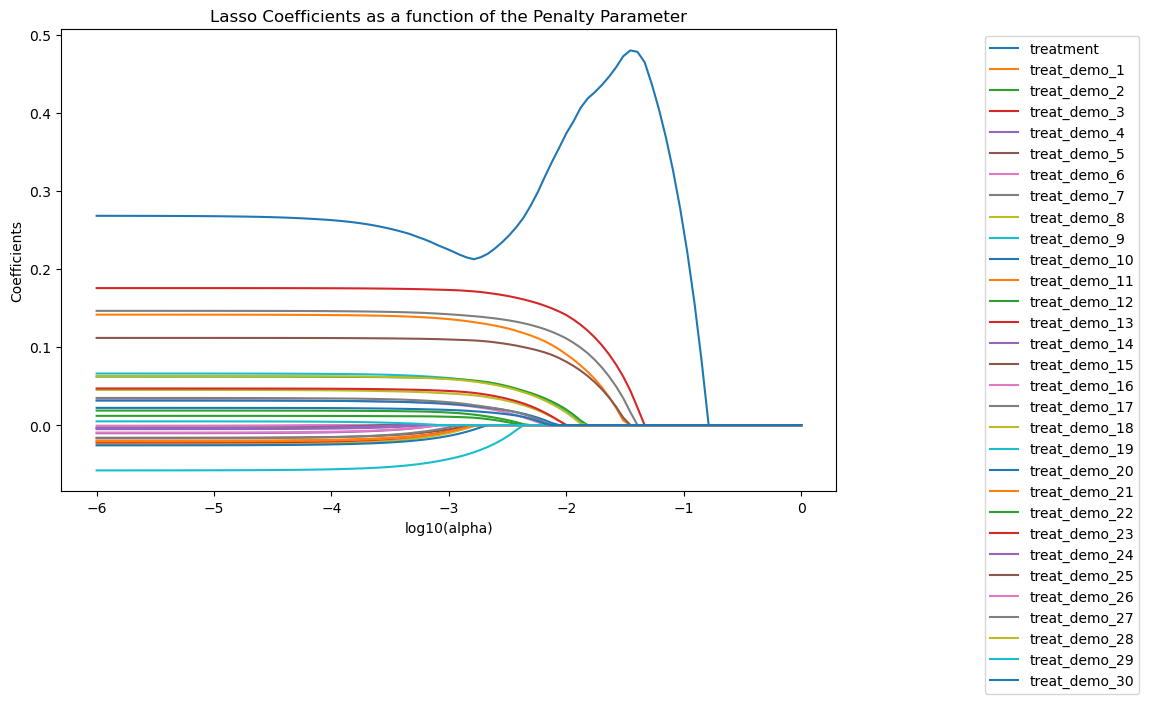

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), coefficients)
plt.xlabel('log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a function of the Penalty Parameter')
plt.legend(X.columns, loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

The non-monotonic behavior is due to the Lasso's feature selection process. As the penalty decreases initially, Lasso selects the feature that provides significant explanatory power, increasing its coefficient relative to those of other variables. With further reduction in the penalty, Lasso begins to include other variables, adjusting their coefficients to strike a balance between the penalty and the overall prediction error. This adjustment leads to a decrease in the treatment's coefficient. That explains why the first line (from right to left) first increases and then decreases.

**Question 2. Run the cross-validated lasso (without standardization) based on the same set of variables. Report the coefficient values for all non-zero coefficients at the optimal penalty value. What do the results suggest regarding the scope for targeting?**

In [10]:
from sklearn.linear_model import LassoCV

In [11]:
def plot_lassoCV(lasso,nfolds):
     #1se rule 
    mean = np.mean(lasso.mse_path_, axis=1)
    std_error = np.std(lasso.mse_path_, axis=1)/np.sqrt(nfolds)
    mean_min  = mean[lasso.alphas_==lasso.alpha_]
    std_min   = std_error[lasso.alphas_==lasso.alpha_]
    alpha_1se = np.max(lasso.alphas_[mean <= mean_min + std_min])

    # Plot    
    plt.semilogx(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))

    plt.semilogx(lasso.alphas_, mean + std_error, "b--")
    plt.semilogx(lasso.alphas_, mean - std_error, "b--")
    plt.fill_between(lasso.alphas_, mean + std_error, mean - std_error, alpha=0.2)
    plt.axvline(lasso.alpha_, linestyle="--", color="black", label="$\lambda_{min}$")
    plt.axvline(alpha_1se, linestyle="--", color="red", label="$\lambda_{1se}$")
    plt.legend()
    plt.xlabel("$\log(\lambda)$")
    plt.ylabel("Mean Squared Error")
    plt.show() 
    
def get_coef(lasso,scale,coeffnames):
    # getting the coefficients and picking those that are not zero
    coefficients = np.append(lasso.intercept_, lasso.coef_/scale) 
    coeffnames = coeffnames[coefficients != 0]
    coeffvalues = coefficients[coefficients != 0]
    # return non-zero ones 
    return pd.DataFrame([coeffnames, coeffvalues]).T


In [12]:
X = pd.concat([ad_heterog[['treatment']], demo_treat_matrix], axis=1)
y = ad_heterog['revenue']

nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) 
lassocv.fit(X,y)

LassoCV(cv=10, max_iter=10000)

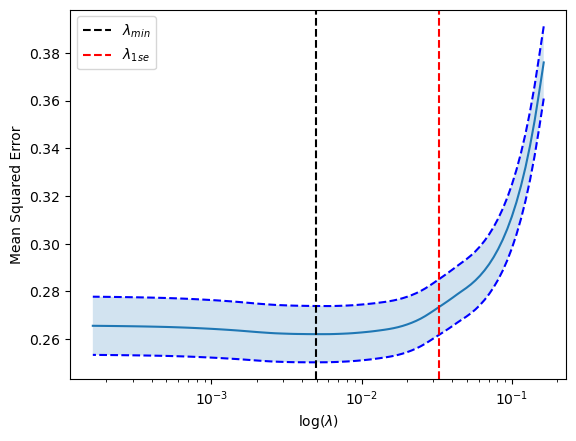

In [13]:
plot_lassoCV(lassocv,nfolds)

In [14]:
coeffnames = list(X.columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv,1,coeffnames)

,0,1
0,(Intercept),5.117759
1,treatment,0.280851
2,treat_demo_1,0.114795
3,treat_demo_3,0.158607
4,treat_demo_7,0.128264
5,treat_demo_9,0.040007
6,treat_demo_16,0.006887
7,treat_demo_18,0.022377
8,treat_demo_20,0.012228
9,treat_demo_22,0.041163


These non-zero coefficients indicate that these variables significantly predict revenue. The positive coefficient for the treatment variable suggests a generally positive impact of the treatment on revenue, indicating that the treatment is effective, but its effectiveness varies across different demographic segments.

With higher positive coefficients, the interaction terms indicate that certain demographic groups are more responsive to the treatment than others, which can be crucial for targeting.

## 3. Lasso with baseline and interacted demographics

**Question 1. Run a cross-validated lasso based on the same variables as above, but now also include the un-interacted demographic variables to the matrix of X variables to try for lasso. Make sure you know how to interpret the coefficients for the demographics that are selected as both slope and intercept dummies as opposed to the demographics that only show up as interaction dummies. For example, consider the case of demographics 3 and 7. Can you compute the treatment effect for both characteristics (i.e., the effect of the treatment on individuals with a certain characteristic vs. individuals with the same characteristic in the control group?).**

In [15]:
X_uninteracted = ad_heterog.drop(columns=['revenue'])
X = pd.concat([X_uninteracted, demo_treat_matrix], axis=1)
y = ad_heterog['revenue']

nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) 
lassocv.fit(X,y)

LassoCV(cv=10, max_iter=10000)

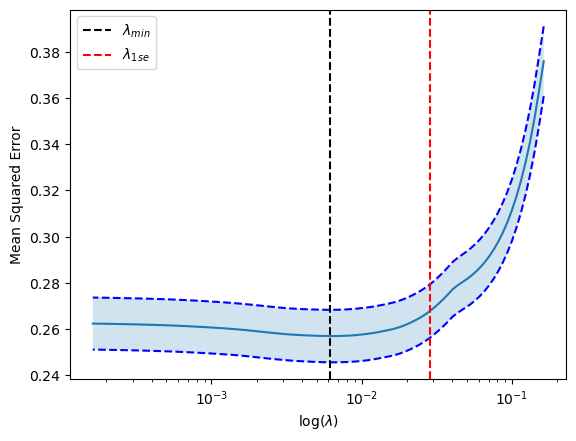

In [16]:
plot_lassoCV(lassocv,nfolds)

In [17]:
coeffnames = list(X.columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv,1,coeffnames)

,0,1
0,(Intercept),4.964982
1,treatment,0.454866
2,demographic_1,0.138043
3,demographic_2,-0.002787
4,demographic_7,0.016443
5,demographic_9,0.034156
6,demographic_11,-0.014056
7,demographic_22,0.032252
8,demographic_23,0.020893
9,demographic_25,0.068269


For Demographic 3, it only appears as an interaction dummy, not as an intercept dummy, indicating that the demographic factor 3 itself does not have a direct effect on the expected revenue. However, when the treatment is applied, it increases the expected revenue by 0.155.

For Demographic 7, it appears both as an interaction dummy and an intercept dummy. This indicates that the demographic factor 7 itself has a direct effect on increasing revenue by 0.016. Additionally, there is an effect of further increasing revenue by 0.107 when the treatment is applied.

**Question 2. For each observation, compute predicted revenue without and with treatment. Use those two predictions to compute the expected profit per consumer when showing the ad to everybody versus when showing the ad only to consumers with positive expected profit.**

In [18]:
from scipy import sparse

In [19]:
treat_always = (ad_heterog["treatment"] >= 0)  

demo_treat_always = demo_matrix.multiply(treat_always, axis="index")
demo_treat_always.columns = demo_treat_always.columns.str.replace("demographic", "treat_demo")

X_always = sparse.csc_matrix(pd.concat([treat_always*1,demo_matrix,demo_treat_always], axis=1))

In [20]:
treat_never = (ad_heterog["treatment"] < 0)

demo_treat_never = demo_matrix.multiply(treat_never, axis="index")
demo_treat_never.columns = demo_treat_never.columns.str.replace("demographic", "treat_demo")

X_never = sparse.csc_matrix(pd.concat([treat_never*1,demo_matrix,demo_treat_never], axis=1))

In [21]:
ad_heterog["treatment_rev"] = lassocv.predict(X_always)
ad_heterog["control_rev"] = lassocv.predict(X_never)

/Users/elenapan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/elenapan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


In [22]:
ad_heterog["showed"] = ad_heterog["treatment_rev"] - ad_heterog["control_rev"] > 0.7
np.mean(ad_heterog["showed"])

0.2605

In [23]:
ad_heterog["simple_profit"] = (ad_heterog["treatment_rev"] - ad_heterog["control_rev"] - 0.7)
ad_heterog["target_profit"] = (ad_heterog["showed"] *(ad_heterog["treatment_rev"] - ad_heterog["control_rev"] - 0.7))

In [24]:
np.mean(ad_heterog["simple_profit"])

-0.06826410916798084

In [25]:
np.mean(ad_heterog["target_profit"])

0.016132434045401902